In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from Vision.ImageHelpers import *
from Vision.SSD import *
from Datasets.RoadDamage import RoadDamageDataset

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True

In [ ]:
imsize = 224
batch_size = 8
data, classes, train_tfms, val_tfms, denorm = RoadDamageDataset('C:/fastai/courses/dl2/data/road_damage_dataset', imsize, batch_size)
num_classes = len(classes) - 1
classes

In [ ]:
class StdConv(nn.Module):
    def __init__(self, n_in, n_out, stride=2, drop_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in, n_out, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        return self.dropout(self.batch_norm(self.relu(self.conv(x))))

In [ ]:
def flatten_conv(x,k=1):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class SSDOut(nn.Module):
    def __init__(self, n_in, k=1):
        super().__init__()
        self.k = k
        self.out_classes = nn.Conv2d(n_in, (num_classes + 1) * self.k, 3, padding=1) # Output for each class + background class
        self.out_boxes = nn.Conv2d(n_in, 4*self.k, 3, padding=1) # Output for bounding boxes
        
    def forward(self, x):
        return [flatten_conv(self.out_classes(x), self.k), F.tanh(flatten_conv(self.out_boxes(x), self.k))] 

class SSDHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.conv_0 = StdConv(512, 256, stride=1)
        self.conv_1 = StdConv(256, 256)
        self.out = SSDOut(256)
        
    def forward(self, x):
        x = self.dropout(F.relu(x))
        x = self.conv_0(x)
        x = self.conv_1(x)
        return self.out(x)
        

In [ ]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, x, bbox, clas=None, prs=None, thresh=0.3, show_bg=False):
    im = np.moveaxis(x, 0, 2)
    bb = [center_to_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im.clip(0,1), ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh) and (show_bg or c != 0)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += classes[c]
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.25, show_bg=False):
    return show_ground_truth(ax, ima, (bbox*imsize),
         clas, prs if prs is not None else None, thresh, show_bg=show_bg)

def test(sess, anchors, grid, data):
    with EvalModel(sess.model):
        rawx, rawy, *_ = next(iter(data))
        pred_classes, bb_outputs = sess.forward(rawx)
        prints = {key: val.numpy() for key, val in rawy.items()}
        y = {key: Variable(value) for key, value in rawy.items()}

        for i, x in enumerate(rawx[0:16]):
            im = denorm(rawx[i]).numpy()

            pred_classes_1, bb_outputs_1 = pred_classes[i], bb_outputs[i]
            label_bbs, label_classes = y['BB'][i], y['CAT'][i]

            fig, axes = plt.subplots(3, 2, figsize=(18, 18))


            # Ground Truth
            show_ground_truth(axes.flat[0], im, prints['BB'][i], prints['CAT'][i])


            # Anchorbox Assignments 
            gt_bbs, gt_classes, *_ = map_label_to_ground_truth(label_bbs, label_classes, anchors, grid, imsize)
            torch_gt(axes.flat[1], im, anchors.cpu().data.numpy(), gt_classes.cpu().data.numpy(), show_bg=False)


            # Predicted classes per anchorbox
            torch_gt(axes.flat[2], im, 
                     anchors.cpu().data.numpy(), 
                     pred_classes_1.max(1)[1].data, 
                     pred_classes_1.max(1)[0].sigmoid().data, 
                     show_bg=True)


            # Predicted classes per anchorbox. No background
            torch_gt(axes.flat[3], im, 
                     anchors.cpu().data.numpy(), 
                     pred_classes_1[:,1:].max(1)[1].data + 1, 
                     pred_classes_1[:,1:].max(1)[0].sigmoid().data, 
                     thresh=0.15,
                     show_bg=False)


            # Predicted class and bounding box
            a_ic = map_bb_outputs_to_pred_bbs(bb_outputs_1, anchors, grids)
            torch_gt(axes.flat[4], im, 
                     a_ic.cpu().data.numpy(), 
                     pred_classes_1[:,1:].max(1)[1].data + 1, 
                     pred_classes_1[:,1:].max(1)[0].sigmoid().data, 
                     thresh=0.15, 
                     show_bg=False)


            # Non Maximum Supression Outputs
            nms_classes, nms_conf, nms_bbs = make_output(pred_classes_1, bb_outputs_1, anchors, grids)
            nms_bbs_as_numpy = torch_corners_to_center(nms_bbs.cpu()).numpy()
            torch_gt(axes.flat[5], im, nms_bbs_as_numpy, nms_classes.cpu().numpy(), nms_conf.cpu().numpy())

In [ ]:
model_ft = models.resnet18(pretrained=True)
layers = list(model_ft.children())[0:-2]
layers += [SSDHead()]
model = nn.Sequential(*list(layers))

In [ ]:
anc_grid = 4
k = 1
 
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
 
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = Variable(torch.from_numpy(np.concatenate([anc_ctrs, anc_sizes], axis=1))).float()
 
grid_wh = np.array([[1/anc_grid, 1/anc_grid]] * len(anchors))
grids = Variable(torch.from_numpy(np.concatenate([anc_ctrs, grid_wh], axis=1))).float()
grids

In [ ]:
anc_grid = 4
k = 1
 
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
 
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = Variable(torch.from_numpy(np.concatenate([anc_ctrs, anc_sizes], axis=1))).float()
 
grid_sizes = Variable(torch.from_numpy(np.array([1/anc_grid]))).unsqueeze(1).float()

anchors

In [ ]:
criterion = SSDLoss(anchors, grids, num_classes, imsize)
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, [*[1e-3] * 8, 1e-2])

In [ ]:
test(sess, anchors, grids, data['valid'])

In [ ]:
rawx, rawy, *_ = next(iter(data['valid'])) 
y = {key: Variable(value) for key, value in rawy.items()}

In [ ]:
raw_label_bbs, raw_label_classes = y['BB'][1], y['CAT'][1]
label_bbs, label_classes = format_label(raw_label_bbs, raw_label_classes, imsize)

In [ ]:
box_similarity(label_bbs, anchors, grids)

In [ ]:
batch = sess.forward(rawx)

In [ ]:
loss = criterion(batch, y)

In [ ]:
lr_find(sess, data['train'], start_lr=1e-7)

In [ ]:
sess.set_lr([*[5e-4 / 2] * 8, 5e-4])

In [ ]:
lr_scheduler = Cyclical(len(data['train']) * 4)
validator = Validator(data['valid'])
schedule = TrainingSchedule(data['train'], [lr_scheduler, validator])

In [ ]:
lr_scheduler.plot(len(data['train']) * 4)

In [ ]:
sess.train(schedule, 3)

In [ ]:
sess.save('ssd_2')

In [ ]:
sess.load('ssd_2')

In [ ]:
test(sess, anchors, grids, data['valid'])

## More Anchors

In [8]:
def var_from_np(arr, requires_grad=True):
    return Variable(torch.from_numpy(arr), requires_grad=requires_grad)

In [9]:
anc_grids = [4,2,1]

anc_zooms = [1.3, 1., .7]

anc_ratios = [(1.,1.), (1.,.5), (.5,1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]

# print(anchor_scales)

k = len(anchor_scales)

anc_offsets = [1/(o*2) for o in anc_grids]

k

9

In [10]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag) for ao, ag in zip(anc_offsets, anc_grids)])

# print(anc_x)

anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag) for ao, ag in zip(anc_offsets, anc_grids)])

# print(anc_y)

anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

# print(anc_ctrs)

In [11]:
anc_sizes = np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o, p in anchor_scales])
               for ag in anc_grids])

np_grid_sizes = np.concatenate([np.array([[1/ag] for i in range(ag*ag) for o, p in anchor_scales])
               for ag in anc_grids])

np_anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1)

np_grid_sizes

array([[0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.

In [12]:
grids = Variable(torch.from_numpy(np.concatenate([anc_ctrs, np_grid_sizes, np_grid_sizes], axis=1))).float()
grids[None,:,3]

Variable containing:

Columns 0 to 9 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

Columns 10 to 19 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

Columns 20 to 29 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

Columns 30 to 39 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

Columns 40 to 49 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

Columns 50 to 59 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

Columns 60 to 69 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

Columns 70 to 79 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

Columns 80 to 89 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

Columns 90 to 99 
 0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500  0.2500

In [13]:
anchors = var_from_np(np_anchors, requires_grad=False).float()
anchors

Variable containing:
 0.1250  0.1250  0.3250  0.3250
 0.1250  0.1250  0.3250  0.1625
 0.1250  0.1250  0.1625  0.3250
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.1250  0.2500  0.1250
 0.1250  0.1250  0.1250  0.2500
 0.1250  0.1250  0.1750  0.1750
 0.1250  0.1250  0.1750  0.0875
 0.1250  0.1250  0.0875  0.1750
 0.1250  0.3750  0.3250  0.3250
 0.1250  0.3750  0.3250  0.1625
 0.1250  0.3750  0.1625  0.3250
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.3750  0.2500  0.1250
 0.1250  0.3750  0.1250  0.2500
 0.1250  0.3750  0.1750  0.1750
 0.1250  0.3750  0.1750  0.0875
 0.1250  0.3750  0.0875  0.1750
 0.1250  0.6250  0.3250  0.3250
 0.1250  0.6250  0.3250  0.1625
 0.1250  0.6250  0.1625  0.3250
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.6250  0.2500  0.1250
 0.1250  0.6250  0.1250  0.2500
 0.1250  0.6250  0.1750  0.1750
 0.1250  0.6250  0.1750  0.0875
 0.1250  0.6250  0.0875  0.1750
 0.1250  0.8750  0.3250  0.3250
 0.1250  0.8750  0.3250  0.1625
 0.1250  0.8750  0.1625  0.3250
 0.1250  0.8750  0.

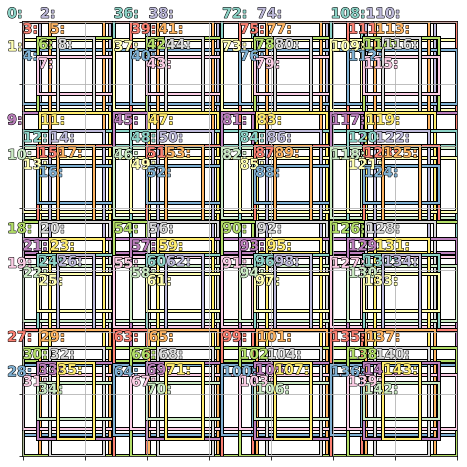

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
show_ground_truth(ax, np.ones((3, 224, 224)), anchors.data.cpu().numpy()[:4*4*9] * 224)

In [15]:
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(.4)
        self.sconv0 = StdConv(512,256, stride=1, drop_p=.4)
        self.sconv1 = StdConv(256,256, drop_p=.4)
        self.sconv2 = StdConv(256,256, drop_p=.4)
        self.sconv3 = StdConv(256,256, drop_p=.4)
        self.out1 = SSDOut(256, k)
        self.out2 = SSDOut(256, k)
        self.out3 = SSDOut(256, k)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)    
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

In [16]:
model_ft = models.resnet18(pretrained=True)
layers = list(model_ft.children())[0:-2]
layers += [SSD_MultiHead(k, -4.)]
model = nn.Sequential(*list(layers))
criterion = SSDLoss(anchors, grids, num_classes, imsize)
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, [*[1e-3] * 8, 1e-2])

In [ ]:
rawx, rawy, *_ = next(iter(data['valid']))

In [ ]:
batch = sess.forward(rawx)

In [ ]:
batch

In [ ]:
test(sess, anchors, grids, data['valid'])

In [ ]:
lr_find(sess, data['train'], start_lr=1e-7)

In [ ]:
sess.set_lr([*[1e-4 / 2] * 8, 1e-4])

In [ ]:
lr_scheduler = Cyclical(len(data['train']) * 7)
accuracy = JaccardAccuracy(anchors, imsize)
validator = Validator(data['valid'], accuracy)
schedule = TrainingSchedule(data['train'], [lr_scheduler, validator])

In [ ]:
validator.run(sess)

In [ ]:
sess.train(schedule, 7)

In [ ]:
sess.save("Resnet18MultiStriped")

In [ ]:
sess.load("Resnet18MultiStriped")

In [ ]:
test(sess, anchors, data['valid'])

In [ ]:
sess.train(schedule, 15)

In [ ]:
sess.save("Resnet34Multi2")

In [ ]:
sess.load("Resnet34Multi2")

In [ ]:
test(sess, anchors, data['valid'])

## Inference Test Data

In [ ]:
def inference_test_data():
    inferences = []

    prints = 0

    with EvalModel(sess.model):
        for x,y,meta in data['test']:
            pred_classes, bb_outputs = sess.forward(x)
            for idx, file in enumerate(meta['file']):
                nms_classes, nms_conf, nms_bbs = make_output(pred_classes[idx], bb_outputs[idx], anchors, grid_sizes)

                if prints < 16 and random.random() <= .01:
                    fig, ax = plt.subplots(figsize=(12,12))
                    ax.set_title(file.split("\\")[-1])
                    im = denorm(x[idx]).numpy()
                    nms_bbs_as_numpy = torch_corners_to_center(nms_bbs.cpu()).numpy()
                    torch_gt(ax, im, nms_bbs_as_numpy, nms_classes.cpu().numpy(), nms_conf.cpu().numpy())
                    prints += 1

                nms_classes, nms_conf, nms_bbs = nms_classes.cpu().numpy(), nms_conf.cpu().numpy(), nms_bbs.cpu().numpy()   

                preds = []

                for idx, cls, bb in zip(range(5), nms_classes, nms_bbs):
                    corners = (bb * 600).clip(0,600).astype(int)
                    assert(corners[0] < corners[2] and corners[1] < corners[3])
                    preds.append(f'{cls} {" ".join(corners.astype(str))}')

                inferences.append({'filename': file.split("\\")[-1], 'prediction': " ".join(preds)})

    df = pd.DataFrame(inferences, columns=['filename', 'prediction'])
    df.to_csv(f'Submissions/submission.{time.strftime("%Y%m%d-%H%M%S")}.csv', header=False, index=False)

In [ ]:
inference_test_data()